# Lab 10: Fully Connected Neural Networks

In this assignment, we will learn fully connected neural network. 


## 1. Example

This assignement should be run on Google Colab where you can use free GPU to accelerate the computation. Please refer to our slides to set up GPU. 

### 1. Install Pytorch

In [1]:
!pip3 install torch torchvision   # install pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 2. Check GPU

In [2]:
!/opt/bin/nvidia-smi  #show GPU 

Sat Apr 29 04:33:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 3. Mount to google drive (optional)

In [3]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 4. Code

In [4]:
#Import Libraries
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [5]:
args={}
args['batch_size']=100
args['test_batch_size']=100
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['log_interval']=100

In [6]:
# build an mlp
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 256)   # linear layer (784 -> 256)
        self.fc2 = nn.Linear(256,128)  # linear layer (256 -> 128)
        self.fc3 = nn.Linear(128,10)  # linear layer (128 -> 10)

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = F.relu(self.fc1(h0)) # hidden layer 1
        h2 = F.relu(self.fc2(h1)) # hidden layer 2
        h3 = self.fc3(h2) # output layer

        return h3

model = Net()
model.cuda() # put the model on GPU
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [7]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(),lr = args['lr'])

In [8]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 400536717.19it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 14051234.64it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 167325350.74it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2025574.56it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        
        output = model(data)
        loss = criterion(output, target)

        # compute gradients
        optimizer.zero_grad()
        loss.backward()

        #to do a one-step update on our parameter.
        optimizer.step()

        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [10]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()

        output = model(data)
        test_loss += criterion(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [11]:
for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327785
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.897645
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.138422
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.744170
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.562380
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.456244

Test set: Average loss: 0.0041, Accuracy: 8902/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.352092
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.377618
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.397309
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.373175
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.446195
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.354354

Test set: Average loss: 0.0030, Accuracy: 9133/10000 (91%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.339862
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.230855
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.274903
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.421262
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.225185
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.

## 2. Tasks

### 1. Please use other activation functions, e.g., sigmoid, tanh, and then plot the training loss and testing accuracy. 

When plotting the training loss, the x-axis is iteration and the y-axis is training loss. When plotting the testing accuracy,  the x-axis is epoch and the y-axis is the training loss.

Sigmoid:

In [26]:
# build an mlp
class NetSigmoid(nn.Module):
    def __init__(self):
        super(NetSigmoid, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 256)   # linear layer (784 -> 256)
        self.fc2 = nn.Linear(256,128)  # linear layer (256 -> 128)
        self.fc3 = nn.Linear(128,10)  # linear layer (128 -> 10)

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = F.sigmoid(self.fc1(h0)) # hidden layer 1
        h2 = F.sigmoid(self.fc2(h1)) # hidden layer 2
        h3 = self.fc3(h2) # output layer

        return h3

model_sigmoid = NetSigmoid()
model_sigmoid.cuda() # put the model on GPU
print(model_sigmoid)

NetSigmoid(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [27]:
# loss function
criterion_sigmoid = nn.CrossEntropyLoss()

# optimizer
optimizer_sigmoid = torch.optim.SGD(model_sigmoid.parameters(),lr = args['lr'])

In [28]:
def train_sigmoid(epoch):
    model_sigmoid.train()
    loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        
        output = model_sigmoid(data)
        loss = criterion_sigmoid(output, target)

        # compute gradients
        optimizer_sigmoid.zero_grad()
        loss.backward()

        #to do a one-step update on our parameter.
        optimizer_sigmoid.step()

        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

In [29]:
def test_sigmoid():
    model_sigmoid.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()

        output = model_sigmoid(data)
        test_loss += criterion_sigmoid(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return 100. * correct / len(test_loader.dataset)

In [30]:
losses_sigmoid = []
accuracy_list_sigmoid = []

for epoch in range(1, args['epochs'] + 1):
    loss = train_sigmoid(epoch)
    accuracy = test_sigmoid()

    losses_sigmoid.append(loss)
    accuracy_list_sigmoid.append(accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.330715
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.286858
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.286228
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.292001
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.282097
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.277742

Test set: Average loss: 0.0226, Accuracy: 1571/10000 (16%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.264272
Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.253796
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.238876
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.233855
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.193068
Train Epoch: 2 [50000/60000 (83%)]	Loss: 2.199981

Test set: Average loss: 0.0217, Accuracy: 4096/10000 (41%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.182087
Train Epoch: 3 [10000/60000 (17%)]	Loss: 2.165404
Train Epoch: 3 [20000/60000 (33%)]	Loss: 2.152994
Train Epoch: 3 [30000/60000 (50%)]	Loss: 2.123628
Train Epoch: 3 [40000/60000 (67%)]	Loss: 2.048989
Train Epoch: 3 [50000/60000 (83%)]	Loss: 1.

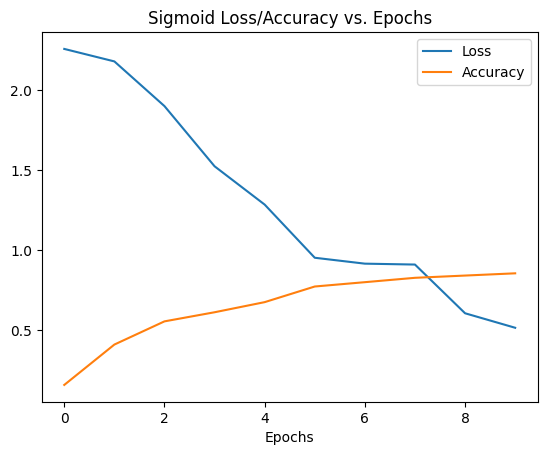

In [32]:
import matplotlib.pyplot as plt

plt.title('Sigmoid Loss/Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.plot([loss for loss in losses_sigmoid], label='Loss')
plt.plot([acc.item() / 100 for acc in accuracy_list_sigmoid], label='Accuracy')
plt.legend()
plt.show()

Tanh:

In [34]:
# build an mlp
class NetTanh(nn.Module):
    def __init__(self):
        super(NetTanh, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 256)   # linear layer (784 -> 256)
        self.fc2 = nn.Linear(256,128)  # linear layer (256 -> 128)
        self.fc3 = nn.Linear(128,10)  # linear layer (128 -> 10)

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = F.tanh(self.fc1(h0)) # hidden layer 1
        h2 = F.tanh(self.fc2(h1)) # hidden layer 2
        h3 = self.fc3(h2) # output layer

        return h3

model_tanh = NetTanh()
model_tanh.cuda() # put the model on GPU
print(model_tanh)

NetTanh(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [35]:
# loss function
criterion_tanh = nn.CrossEntropyLoss()

# optimizer
optimizer_tanh = torch.optim.SGD(model_tanh.parameters(),lr = args['lr'])

In [36]:
def train_tanh(epoch):
    model_tanh.train()
    loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        
        output = model_tanh(data)
        loss = criterion_tanh(output, target)

        # compute gradients
        optimizer_tanh.zero_grad()
        loss.backward()

        #to do a one-step update on our parameter.
        optimizer_tanh.step()

        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

In [37]:
def test_tanh():
    model_tanh.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()

        output = model_tanh(data)
        test_loss += criterion_tanh(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return 100. * correct / len(test_loader.dataset)

In [38]:
losses_tanh = []
accuracy_list_tanh = []

for epoch in range(1, args['epochs'] + 1):
    loss = train_tanh(epoch)
    accuracy = test_tanh()

    losses_tanh.append(loss)
    accuracy_list_tanh.append(accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314583
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.469591
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.925936
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.780192
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.678566
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.628849

Test set: Average loss: 0.0045, Accuracy: 8919/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.514593
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.355954
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.230998
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.395193
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.353329
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.415220

Test set: Average loss: 0.0033, Accuracy: 9112/10000 (91%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.337340
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.297910
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.285969
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.253803
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.326085
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.

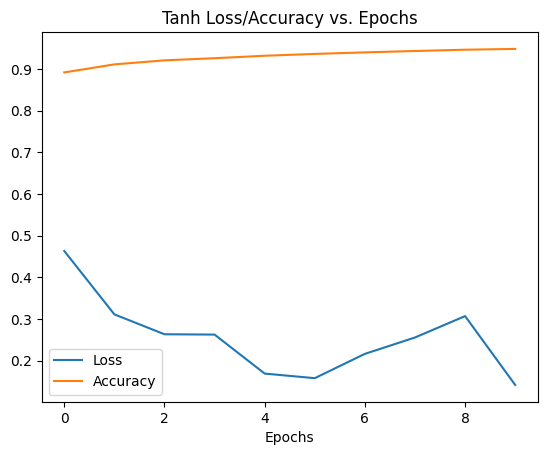

In [48]:
import matplotlib.pyplot as plt

plt.title('Tanh Loss/Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.plot([loss for loss in losses_tanh], label='Loss')
plt.plot([acc.item() / 100 for acc in accuracy_list_tanh], label='Accuracy')
plt.legend()
plt.show()

### 2. Please use different layers in the model, e.g., 1 layer, 5 layers, 10 layers,  and then plot the training loss and testing accuracy.

1 layer:

In [51]:
# build an mlp
class NetOneLayer(nn.Module):
    def __init__(self):
        super(NetOneLayer, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 10)   # linear layer (784 -> 10)

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = F.relu(self.fc1(h0)) # hidden layer 1

        return h1

model_one_layer = NetOneLayer()
model_one_layer.cuda() # put the model on GPU
print(model_one_layer)

NetOneLayer(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)


In [52]:
# loss function
criterion_one_layer = nn.CrossEntropyLoss()

# optimizer
optimizer_one_layer = torch.optim.SGD(model_one_layer.parameters(),lr = args['lr'])

In [53]:
def train_one_layer(epoch):
    model_one_layer.train()
    loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        
        output = model_one_layer(data)
        loss = criterion_one_layer(output, target)

        # compute gradients
        optimizer_one_layer.zero_grad()
        loss.backward()

        #to do a one-step update on our parameter.
        optimizer_one_layer.step()

        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

In [54]:
def test_one_layer():
    model_one_layer.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()

        output = model(data)
        test_loss += criterion_one_layer(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return 100. * correct / len(test_loader.dataset)

In [55]:
losses_one_layer = []
accuracy_list_one_layer = []

for epoch in range(1, args['epochs'] + 1):
    loss = train_one_layer(epoch)
    accuracy = test_one_layer()

    losses_one_layer.append(loss)
    accuracy_list_one_layer.append(accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325093
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.793018
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.482458
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.346771
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.426886
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.387705

Test set: Average loss: 0.0015, Accuracy: 9557/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.490653
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.411139
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.491730
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.492235
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.451535
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.467936

Test set: Average loss: 0.0015, Accuracy: 9557/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.295835
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.357017
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.427116
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.217906
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.298347
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.

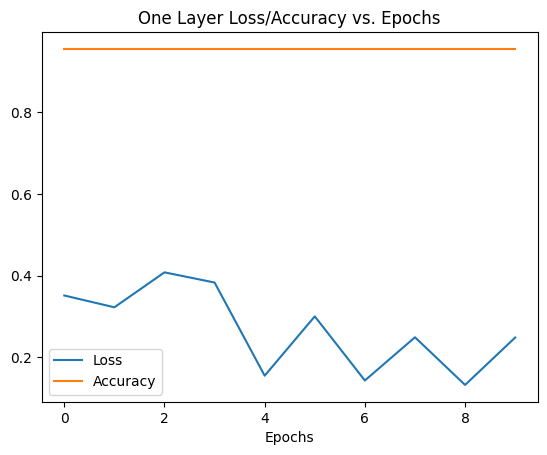

In [56]:
import matplotlib.pyplot as plt

plt.title('One Layer Loss/Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.plot([loss for loss in losses_one_layer], label='Loss')
plt.plot([acc.item() / 100 for acc in accuracy_list_one_layer], label='Accuracy')
plt.legend()
plt.show()

5 layers:

In [57]:
# build an mlp
class NetFiveLayers(nn.Module):
    def __init__(self):
        super(NetFiveLayers, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 128)   # linear layer (784 -> 128)
        self.fc2 = nn.Linear(128, 64)   # linear layer (128 -> 64)
        self.fc3 = nn.Linear(64, 32)   # linear layer (64 -> 32)
        self.fc4 = nn.Linear(32, 16)   # linear layer (32 -> 16)
        self.fc5 = nn.Linear(16, 10)   # linear layer (16 -> 10)

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = F.relu(self.fc1(h0)) # hidden layer 1
        h2 = F.relu(self.fc2(h1)) # hidden layer 2
        h3 = F.relu(self.fc3(h2)) # hidden layer 3
        h4 = F.relu(self.fc4(h3)) # hidden layer 4
        h5 = self.fc5(h4) # output layer

        return h5

model_five_layers = NetFiveLayers()
model_five_layers.cuda() # put the model on GPU
print(model_five_layers)

NetFiveLayers(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=10, bias=True)
)


In [58]:
# loss function
criterion_five_layers = nn.CrossEntropyLoss()

# optimizer
optimizer_five_layers = torch.optim.SGD(model_five_layers.parameters(),lr = args['lr'])

In [59]:
def train_five_layers(epoch):
    model_five_layers.train()
    loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        
        output = model_five_layers(data)
        loss = criterion_five_layers(output, target)

        # compute gradients
        optimizer_five_layers.zero_grad()
        loss.backward()

        #to do a one-step update on our parameter.
        optimizer_five_layers.step()

        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

In [60]:
def test_five_layers():
    model_five_layers.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()

        output = model(data)
        test_loss += criterion_five_layers(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return 100. * correct / len(test_loader.dataset)

In [61]:
losses_five_layers = []
accuracy_list_five_layers = []

for epoch in range(1, args['epochs'] + 1):
    loss = train_five_layers(epoch)
    accuracy = test_five_layers()

    losses_five_layers.append(loss)
    accuracy_list_five_layers.append(accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.330528
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.298578
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.316647
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.280205
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.225817
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.230194

Test set: Average loss: 0.0015, Accuracy: 9557/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.009224
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.978200
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.800181
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.609325
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.221334
Train Epoch: 2 [50000/60000 (83%)]	Loss: 1.031733

Test set: Average loss: 0.0015, Accuracy: 9557/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.007164
Train Epoch: 3 [10000/60000 (17%)]	Loss: 1.007540
Train Epoch: 3 [20000/60000 (33%)]	Loss: 1.088130
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.934075
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.584727
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.

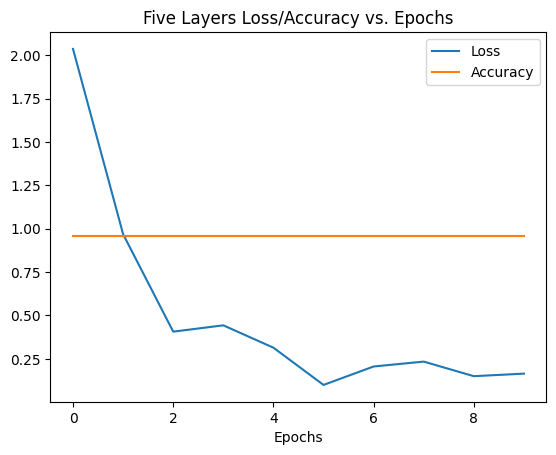

In [62]:
import matplotlib.pyplot as plt

plt.title('Five Layers Loss/Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.plot([loss for loss in losses_five_layers], label='Loss')
plt.plot([acc.item() / 100 for acc in accuracy_list_five_layers], label='Accuracy')
plt.legend()
plt.show()

Ten layers:

In [63]:
# build an mlp
class NetTenLayers(nn.Module):
    def __init__(self):
        super(NetTenLayers, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 512)   # linear layer (784 -> 512)
        self.fc2 = nn.Linear(512, 256)   # linear layer (512 -> 256)
        self.fc3 = nn.Linear(256, 128)   # linear layer (256 -> 128)
        self.fc4 = nn.Linear(128, 64)   # linear layer (256 -> 128)
        self.fc5 = nn.Linear(64, 32)   # linear layer (64 -> 32)
        self.fc6 = nn.Linear(32, 16)   # linear layer (32 -> 16)
        self.fc7 = nn.Linear(16, 8)   # linear layer (16 -> 8)
        self.fc8 = nn.Linear(8, 4)   # linear layer (8 -> 4)
        self.fc9 = nn.Linear(4, 2)   # linear layer (4 -> 2)
        self.fc10 = nn.Linear(2, 10)   # linear layer (2 -> 10)

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = F.relu(self.fc1(h0)) # hidden layer 1
        h2 = F.relu(self.fc2(h1)) # hidden layer 2
        h3 = F.relu(self.fc3(h2)) # hidden layer 3
        h4 = F.relu(self.fc4(h3)) # hidden layer 4
        h5 = F.relu(self.fc5(h4)) # hidden layer 5
        h6 = F.relu(self.fc6(h5)) # hidden layer 6
        h7 = F.relu(self.fc7(h6)) # hidden layer 7
        h8 = F.relu(self.fc8(h7)) # hidden layer 8
        h9 = F.relu(self.fc9(h8)) # hidden layer 9
        h10 = self.fc10(h9) # output layer

        return h10

model_ten_layers = NetTenLayers()
model_ten_layers.cuda() # put the model on GPU
print(model_ten_layers)

NetTenLayers(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=16, bias=True)
  (fc7): Linear(in_features=16, out_features=8, bias=True)
  (fc8): Linear(in_features=8, out_features=4, bias=True)
  (fc9): Linear(in_features=4, out_features=2, bias=True)
  (fc10): Linear(in_features=2, out_features=10, bias=True)
)


In [64]:
# loss function
criterion_ten_layers = nn.CrossEntropyLoss()

# optimizer
optimizer_ten_layers = torch.optim.SGD(model_ten_layers.parameters(),lr = args['lr'])

In [65]:
def train_ten_layers(epoch):
    model_ten_layers.train()
    loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        
        output = model_ten_layers(data)
        loss = criterion_ten_layers(output, target)

        # compute gradients
        optimizer_ten_layers.zero_grad()
        loss.backward()

        #to do a one-step update on our parameter.
        optimizer_ten_layers.step()

        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

In [66]:
def test_ten_layers():
    model_ten_layers.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()

        output = model(data)
        test_loss += criterion_ten_layers(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return 100. * correct / len(test_loader.dataset)

In [67]:
losses_ten_layers = []
accuracy_list_ten_layers = []

for epoch in range(1, args['epochs'] + 1):
    loss = train_ten_layers(epoch)
    accuracy = test_ten_layers()

    losses_ten_layers.append(loss)
    accuracy_list_ten_layers.append(accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.344265
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.358868
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.320613
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.339615
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.302228
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.330927

Test set: Average loss: 0.0015, Accuracy: 9557/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.313117
Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.326921
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.319782
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.318413
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.297548
Train Epoch: 2 [50000/60000 (83%)]	Loss: 2.307275

Test set: Average loss: 0.0015, Accuracy: 9557/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.302700
Train Epoch: 3 [10000/60000 (17%)]	Loss: 2.304250
Train Epoch: 3 [20000/60000 (33%)]	Loss: 2.308231
Train Epoch: 3 [30000/60000 (50%)]	Loss: 2.305669
Train Epoch: 3 [40000/60000 (67%)]	Loss: 2.308044
Train Epoch: 3 [50000/60000 (83%)]	Loss: 2.

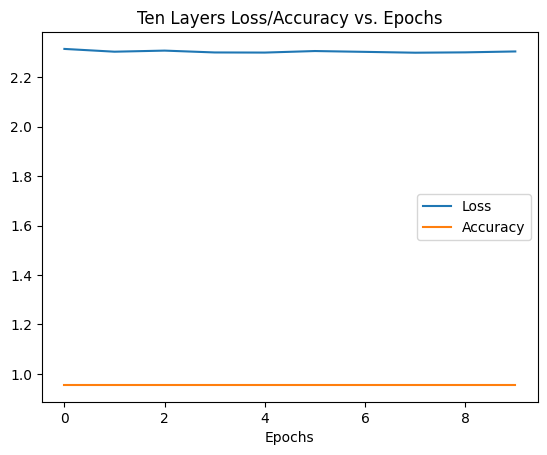

In [69]:
import matplotlib.pyplot as plt

plt.title('Ten Layers Loss/Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.plot([loss for loss in losses_ten_layers], label='Loss')
plt.plot([acc.item() / 100 for acc in accuracy_list_ten_layers], label='Accuracy')
plt.legend()
plt.show()